In [116]:
import os
import warnings

import numpy as np 

from scipy.stats import chisquare

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std, gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling import models, fitting, functional_models, Parameter, custom_model
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u

from astropy.stats import gaussian_fwhm_to_sigma

from photutils import detect_threshold
from photutils import deblend_sources
from photutils import source_properties
from photutils import detect_sources
from photutils import source_properties, EllipticalAperture

from astropy.convolution import Gaussian2DKernel, AiryDisk2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture

In [117]:
from lcbg.utils import cutout, measure_fwhm
from lcbg.fitting import plot_fit, fit_model, model_subtract

In [118]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

In [119]:
import ipywidgets as widgets
from IPython.display import display

# Load

In [120]:
input_data_path = "https://archive.stsci.edu/pub/hlsp/frontier/abell370/images/hst/v1.0-epoch2/hlsp_frontier_hst_wfc3-30mas_abell370_f105w_v1.0-epoch2_drz.fits"
input_data_path = "https://archive.stsci.edu/pub/hlsp/frontier/abell370/images/hst/v1.0-epoch2/hlsp_frontier_hst_wfc3-30mas-bkgdcor_abell370_f105w_v1.0-epoch2_drz.fits"
#input_data_path = "https://archive.stsci.edu/pub/hlsp/frontier/abell370/images/hst/v1.0-epoch2/hlsp_frontier_hst_acs-30mas-selfcal_abell370-hffpar_f435w_v1.0-epoch2_drz.fits"
#input_data_path = "/Users/rgeda/project/data/lcbg/hlsp_frontier_hst_acs-30mas_abell370/hlsp_frontier_hst_acs-30mas_abell370-hffpar_f435w_v1.0-epoch2_drz.fits"
#input_data_path = "https://archive.stsci.edu/pub/hlsp/frontier/abell370/images/hst/v1.0-epoch2/hlsp_frontier_hst_wfc3-60mas_abell370_f105w_v1.0-epoch2_drz.fits"
output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

print("Output: ", output_path)

Output:  hlsp_frontier_hst_wfc3-30mas-bkgdcor_abell370_f105w_v1.0-epoch2_drz_catalog.csv


In [121]:
hdul = fits.open(input_data_path)
hdu = hdul[0]

In [122]:
data = hdu.data
header = hdu.header
wcs = WCS(header)

In [123]:
mean_noise = 0.000312165

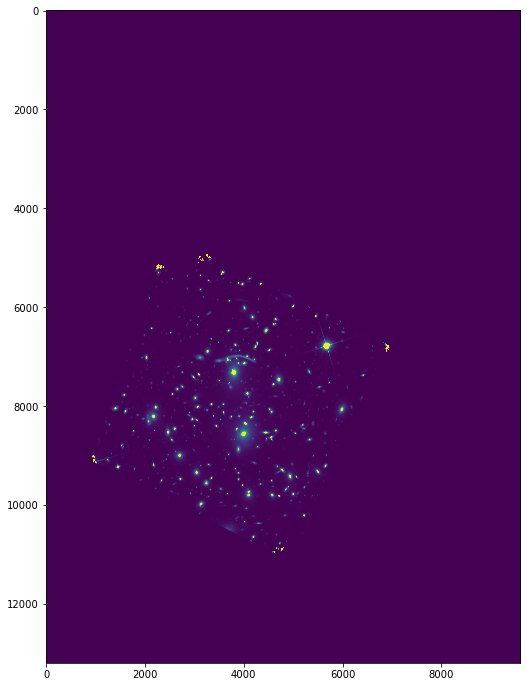

In [124]:
plt.imshow(data, vmin=0, vmax=mean_noise*500)

# Fit

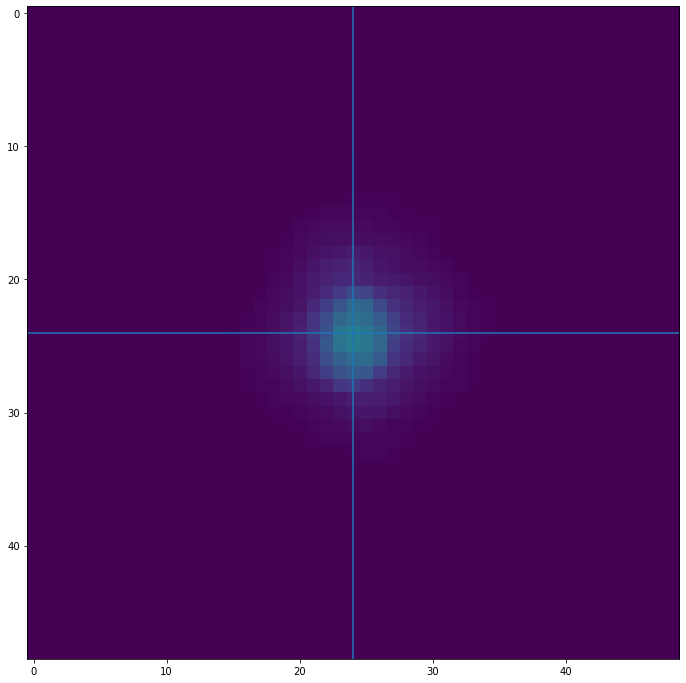

Image Max: 0.2165362685918808
Amplitude: 0.2044516342373839
Center: (24.274693673406066, 24.215520330400114)
Sigma = (2.5628586099676345, 2.9048874000522966)
Mean FWHM: 6 Pix 
FWHM: (x=6.035070827331941, y=6.840487078200987) Pix 


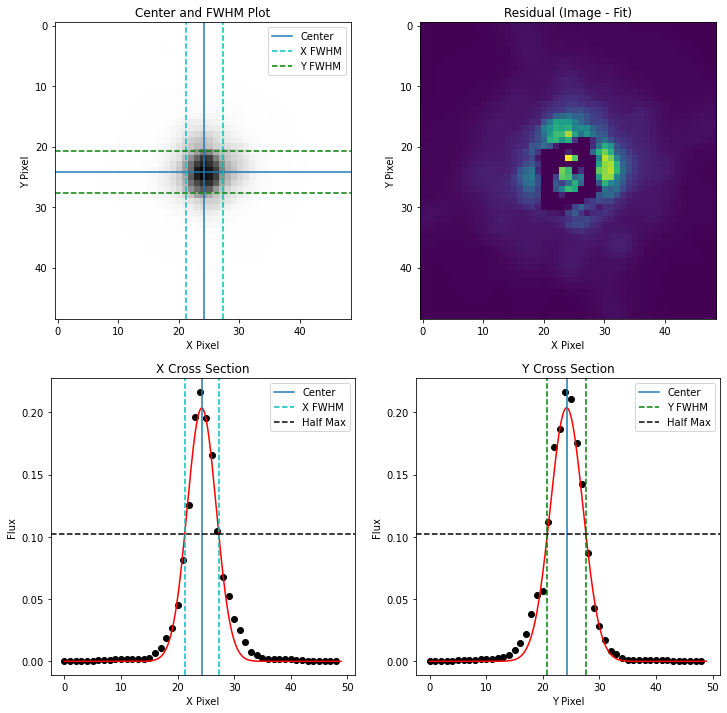

11.862731


In [125]:
PSF = cutout(data, 5671, 6789, 30, vmin=0)
PSF = cutout(data, 3970, 5542, 50, vmin=0)

PSF = PSF[:-1, :-1]
PSF = PSF / np.linalg.norm(PSF)

plt.imshow(PSF, vmin=0, vmax=0.5)
plt.axhline(PSF.shape[0]//2)
plt.axvline(PSF.shape[0]//2)
plt.show()

measure_fwhm(PSF)
print(PSF.sum())

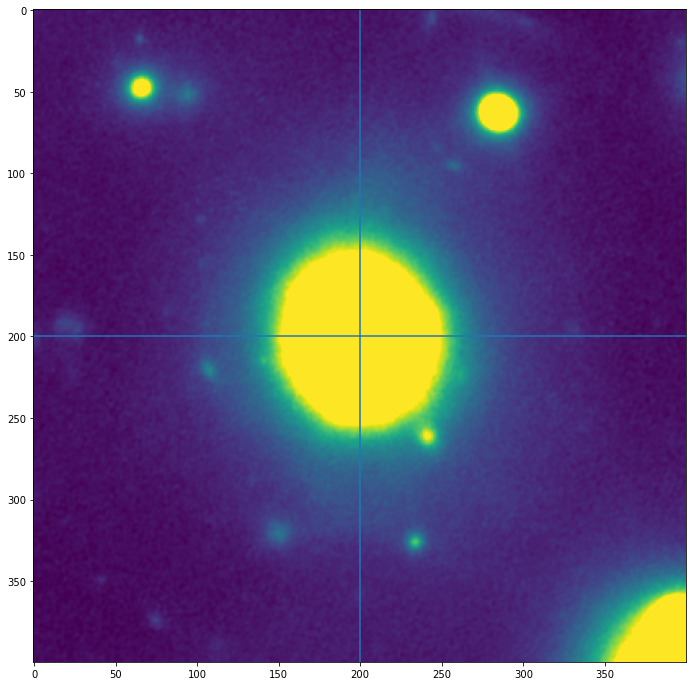

In [374]:
#cx, cy = wcs.world_to_pixel_values(header["RA_TARG"], header["DEC_TARG"])
#image = cutout(data, int(cx), int(cy), 6000)
#image = cutout(data, int(cx), int(cy), 4000)

#image = cutout(data,3595, 6377,  2000)
#image = cutout(data, 2072, 8309, 1000)

#image = cutout(data, 3791, 7332, 1000) # cd arch
#image = cutout(data, 3044, 9348,  1000)
#image = cutout(data, 3065, 6547, 200, vmin=0) # small dwarf
image = cutout(data, 5981, 8072,  400) # bean
image = cutout(data, 3044, 9346, 400) #ball
#image = cutout(data, 4173, 6206, 200)

#image = data[1000:-1000,1000:-1000]

#image -= mean_noise
#mean_noise = image.mean()
plt.imshow(image, vmin=0, vmax=mean_noise*100)
plt.axhline(image.shape[0]//2)
plt.axvline(image.shape[0]//2)
plt.show()

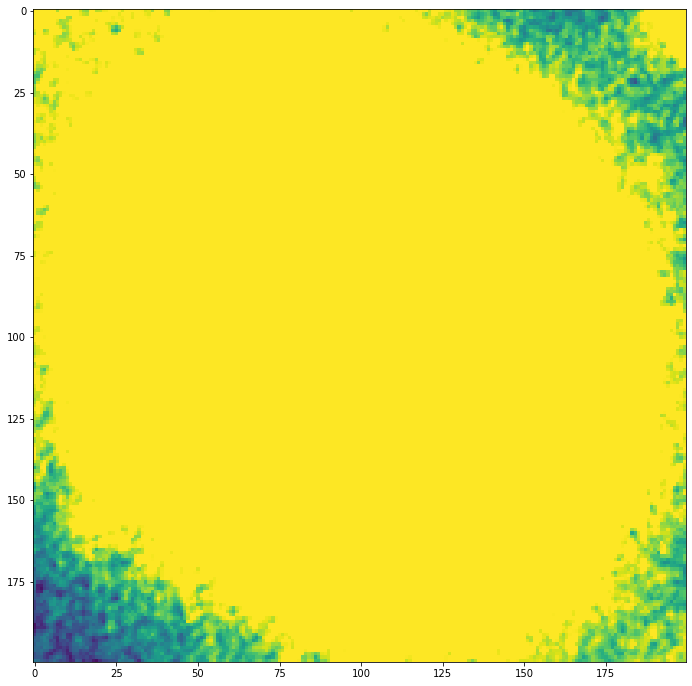

In [127]:
plt.imshow(image, vmin=0, vmax=mean_noise*10)

In [128]:
from scipy.interpolate import interp1d
def estimate_params(image, amp=1, r_eff=30, n=2):
    print(image.shape)
    y_0, x_0 = np.array(image.shape) // 2 
    
    y_arange, x_arange = np.mgrid[y_0:image.shape[0], x_0:image.shape[1]]
    y_arange_fine = np.arange(y_0, image.shape[0]-1, 0.1)
    x_arange_fine = np.arange(x_0, image.shape[1]-1, 0.1)
    
    x = x_arange[1, :]
    y = image[int(np.round(y_0)), x_0:]
    
    f = interp1d(x, y, kind='cubic')
    
    x = x_arange_fine
    y = f(x)
    
    model_x = models.Sersic1D(y.max(), r_eff, n, fixed={'n':True}, bounds={'amplitude':(0, amp), "r_eff":{0,None}})
    #model_x *= models.Const1D(1)


    #model_x += models.Sersic1D(0, None, n, bounds={'amplitude':(0, amp), 'n':(0, 2), "r_eff":{0,None}}) * models.Const1D(1)


    #model_x += models.Polynomial1D(1)
    #model_x = Exponential1d(bounds={'amplitude':(0, amp), 'n':(0, 6),} )
    #model_x += models.Gaussian1D(amplitude=amp, stddev=r_eff)
    #model_x += models.Const1D(0)
    
    
    fit = fitting.LevMarLSQFitter()
    model_x = fit(model_x, x, y, maxiter=50000, epsilon=1e-1000, acc=1e-10)
    
    
    plt.scatter(x, model_x(x), c='r')
    plt.scatter(x, y, c='black')
    plt.axhline(0)
    plt.axvline(x_0)
    
    print("\n".join([str(j) for j in zip(model_x.param_names, model_x.parameters)]))
    
    

(50, 50)
('amplitude', 1506210.3660492704)
('r_eff', 0.43328838240150336)
('n', 4.0)


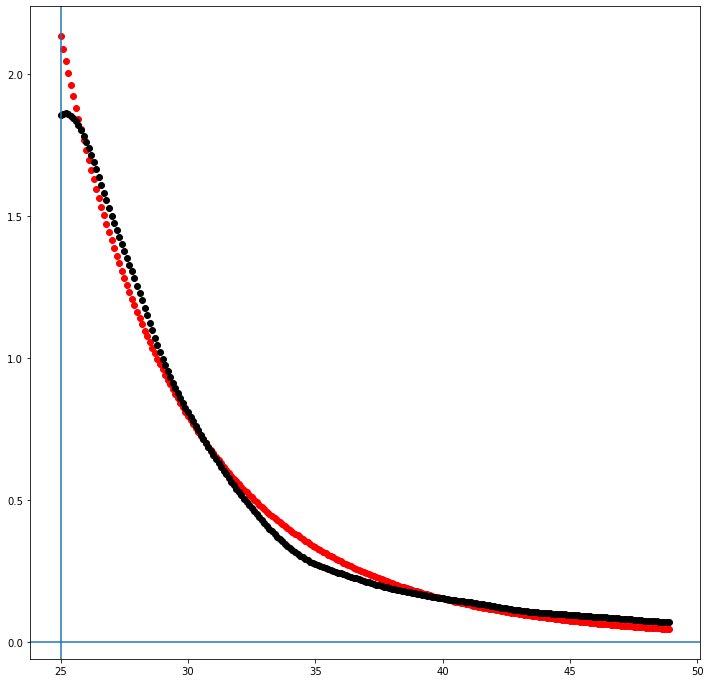

In [129]:
target = cutout(image, image.shape[0]//2, image.shape[0]//2, 50)
estimate_params(target, amp=None, r_eff=None, n=4)

In [130]:
from ipywidgets import interact, interact_manual

In [131]:
def f(amp, n, r_eff):
    y_0, x_0 = np.array(target.shape) // 2

    y_arange, x_arange = np.mgrid[:target.shape[0], :target.shape[1]]

    x = x_arange
    y = y_arange

    model= models.Sersic2D(
        amplitude=amp,
        n=n,
        r_eff=r_eff,
        ellip=0.,
        theta=0.,
        x_0 = x_0,
        y_0 = y_0,
        fixed={'x_0':True, 'y_0':True, 'n':True},
        bounds={
            'amplitude':(0, None),
            'r_eff':(0, None),
             'n':(0, 6),
            'ellip':(0, 1),
            'theta':(0, 2*np.pi),
            #'x_0': (x_0-xy_slack, x_0+xy_slack),
            #'y_0': (y_0-xy_slack, y_0+xy_slack),
        })

    #fit = fitting.LevMarLSQFitter()
    #model = fit(model, x, y, target, maxiter=50000, acc=1e-10,)
    plot_fit(target, model, vmin=0, vmax=mean_noise*800)
    display(amp)

interact_manual(f, 
         amp=widgets.FloatText(min=0, max=0.001, value=0, step=0.001),
         n=widgets.FloatSlider(min=0, max=8, value=4),
         r_eff=widgets.FloatText(min=0, max=np.array(target.shape[0])*10, value=10)
        
        );


interactive(children=(FloatText(value=0.0, description='amp', step=0.001), FloatSlider(value=4.0, description=…

In [132]:
PSF.shape

(49, 49)

In [133]:
from astropy.convolution import convolve

In [134]:
@custom_model
def Nuker(x, y, amplitude=1, r_eff=1, x_0=0, y_0=0, a=1, b=2, g=0):
    r = np.sqrt((x-x_0)**2 + (y-y_0)**2)
    return 2**((b-g)/a)*amplitude*(r_eff/r)**(g)*(1+(r/r_eff)**a)**((g-b)/a)

In [135]:
@custom_model
def Nuker2D(x, y, amplitude=1, r_eff=1, x_0=0, y_0=0, a=1, b=2, g=0, ellip=0, theta=0):
    
    A, B = 1*r_eff, (1 - ellip)*r_eff
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    x_maj = (x - x_0) * cos_theta + (y - y_0) * sin_theta
    x_min = -(x - x_0) * sin_theta + (y - y_0) * cos_theta
    r = np.sqrt((x_maj / A) ** 2 + (x_min / B) ** 2)
    
    return 2**((b-g)/a)*amplitude*(r_eff/r)**(g)*(1+(r/r_eff)**a)**((g-b)/a)

In [140]:
from astropy.convolution import discretize_model

In [390]:
def rebin(a, factor):
    b = np.zeros(np.array(a.shape)//factor)
    
    for i in range(b.shape[0]):
        for j in range(b.shape[1]):
            b[i, j] = a[factor*i:(factor)*(i+1), factor*j:(factor)*(j+1)].sum()
    return b

In [412]:
@custom_model
def SerConv(x, y, amplitude=1, r_eff=1, n=1, x_0=0, y_0=0, ellip=0, theta=0, factor=4):
    """Two dimensional Moffat function."""
    factor = int(factor)
    model = models.Sersic2D(
        amplitude=amplitude,
        n=n,
        r_eff=r_eff,
        ellip=ellip,
        theta=theta,
        x_0 = x_0*factor,
        y_0 = y_0*factor,
    )
    #kernel = AiryDisk2DKernel(8)
    #kernel = Gaussian2DKernel(x_stddev=19, x_size=11, y_size=11)
    #kernel.normalize()
    #kernel = PSF
    y_arange, x_arange = np.mgrid[y.min():y.max()*(factor)+factor, x.min():x.max()*(factor)+factor]
    image = model(x_arange, y_arange)
    #image = convolve(image, kernel)
    #image = discretize_model(model, (x.min(), int(x.max())+1), (y.min(), int(y.max())+1), factor=int(2), mode='integrate')
    image = rebin(image, factor)
    #image = model(x, y)
    #image[int(y_0), int(x_0)] = image[int(y_0)+1, int(x_0)+1]
    
    return image

In [387]:
('amplitude', 0.308172960857093)
('r_eff', 15.922110968889056)
('n', 1.4013187500490014)
('x_0', 50.0)
('y_0', 50.0)
('ellip', 0.0)
('theta', 0.0)

('theta', 0.0)

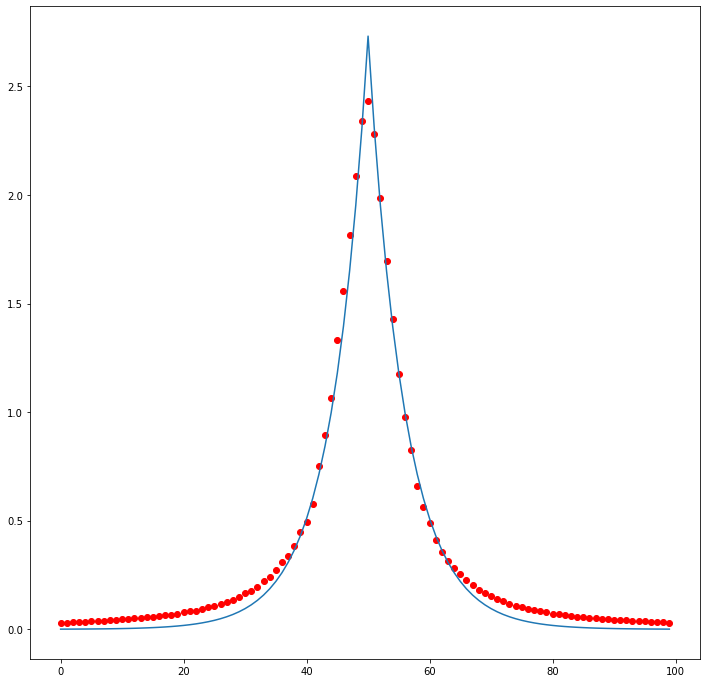

In [457]:
size = target.shape[0]
y_0 = x_0 = size // 2
y_arange, x_arange = np.mgrid[:size, :size]
model=  SerConv(amplitude=0.51, r_eff=10, x_0=x_0, y_0=y_0, n=1, factor=1)
plt.plot(x_arange[1], model(x_arange, y_arange)[int(y_0)])
plt.scatter(x_arange[1], target[size//2]-mean_noise, c='r')

In [182]:
>>> @custom_model
... def Moffat2D(x, y, amplitude=1.0, x_0=0.0, y_0=0.0, gamma=1.0, alpha=1.0):
...     """Two dimensional Moffat function."""
...     rr_gg = ((x - x_0) ** 2 + (y - y_0) ** 2) / gamma ** 2
...     return amplitude * (1 + rr_gg) ** (-alpha)

In [183]:
@custom_model
def Moffat2D(x, y, amplitude=1.0, x_0=0.0, y_0=0.0, gamma=1.0, alpha=1.0, ellip=0, theta=0, r=1):
    """Two dimensional Moffat function."""
    
    a, b = 1*r, (1 - ellip)*r
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    x_maj = (x - x_0) * cos_theta + (y - y_0) * sin_theta
    x_min = -(x - x_0) * sin_theta + (y - y_0) * cos_theta
    z = np.sqrt((x_maj / a) ** 2 + (x_min / b) ** 2)
    
    rr_gg = (z) / gamma ** 2
    
    return amplitude * (1 + rr_gg) ** (-alpha)

In [419]:
from scipy.interpolate import interp1d
def estimate_params2d(image, amp=1, r_eff=30, n=2):
    
    y_0, x_0 = np.array(image.shape) // 2
    
    y_arange, x_arange = np.mgrid[:image.shape[0], :image.shape[1]]
    
    x = x_arange
    y = y_arange
    
    xy_slack = 100
    model=  SerConv(
                amplitude=image.max(), #
                n=0.5,
                r_eff=r_eff,
                ellip=0.0,
                theta=0.0,
                x_0 = x_0,
                y_0 = y_0,
        factor=2,
                fixed={'x_0':True, 'y_0':True, 'factor':True}, #'ellip':True, 'theta':True},
                bounds={
                    'amplitude':(0, None),
                    'r_eff':(0, None),
                     'n':(0, 6),
                    'ellip':(0, 0.9),
                    'theta':(0, 2*np.pi),
                    'x_0': (x_0-xy_slack, x_0+xy_slack),
                    'y_0': (y_0-xy_slack, y_0+xy_slack),
                })
    
   
    fit = fitting.LevMarLSQFitter()
    #model = fit(model, x, y, image, maxiter=50000, epsilon=1e-1)
    
    model_1= models.Sersic2D(
                amplitude=0.1, #
                n=0.5,
                r_eff=model.r_eff*4,
                ellip=0,
                theta=0,
                x_0 = model.x_0,
                y_0 = model.y_0,
                fixed={'x_0':True, 'y_0':True,},
                bounds={
                    'amplitude':(0, None),
                    'r_eff':(0., None),
                     'n':(0.5, 6),
                    'ellip':(0, 1),
                    'theta':(0, 2*np.pi),
                    #'x_0': (x_0-xy_slack, x_0+xy_slack),
                    #'y_0': (y_0-xy_slack, y_0+xy_slack),
                })
    
    model_2 = models.AiryDisk2D(
        x_0 = model.x_0,
        y_0 = model.y_0,
        fixed={'x_0':True, 'y_0':True,},
        bounds={'amplitude':(0, None)},
                
    )
    
    model_3 = models.Gaussian2D(
        amplitude=amp,
        x_mean=model.x_0,
        y_mean=model.y_0,
        fixed={'x_mean': True, 'y_mean': True,},
        bounds={'amplitude':(0, None)},
    )
    
    model_4 = Moffat2D(
        amplitude=image.max(),
        x_0 = model.x_0,
        y_0 = model.y_0,
        ellip=model.ellip,
        theta=model.theta,
        #fixed={'x_0':True, 'y_0':True},
        bounds={
                'amplitude':(0, None),
                'ellip':(0, 1), 'theta':(0, 2*np.pi),
                'x_0': (x_0-xy_slack, x_0+xy_slack),
                'y_0': (y_0-xy_slack, y_0+xy_slack),
            }
    
    )
    
    model_5 = Nuker2D(
        amplitude=image.max(),
        x_0 = model.x_0,
        y_0 = model.y_0,
        theta=3*np.pi/4,
        fixed={'x_0':True, 'y_0':True},
        bounds={
                'amplitude':(0, None),
            'g':(0,None), 
            'ellip':(0, 1), 'theta':(0, np.pi*2),
                #'x_0': (x_0-xy_slack, x_0+xy_slack),
                #'y_0': (y_0-xy_slack, y_0+xy_slack),
            }
    
    )
    

    model =  model

    fit = fitting.LevMarLSQFitter()
    model = fit(model, x, y, image, maxiter=50000, acc=1e-10, epsilon=1e-20)
    #model = fit(model, x, y, image, maxiter=50000, acc=1e-50, epsilon=1e-50)
    model.x_0 = x_0
    model.y_0 = y_0


    plot_fit(image, model, vmin=0, vmax=mean_noise*200)
    
    print("\n".join([str(j) for j in zip(model.param_names, model.parameters)]))
    
    return model

('amplitude', 0.07090742129708788)
('r_eff', 33.36663855836242)
('n', 1.4793499154794663)
('x_0', 50.0)
('y_0', 50.0)
('ellip', 0.0)
('theta', 6.283185307179586)
('factor', 2.0)


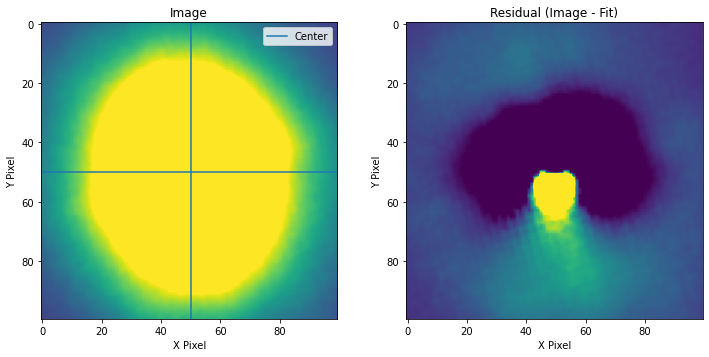

In [420]:
target = cutout(image, image.shape[0]//2, image.shape[0]//2, 100)
model = estimate_params2d(target, amp=target.max(), r_eff=20, n=3)

In [988]:
model.ellip

Parameter('ellip', value=0.0, bounds=(0.0, 1.0))

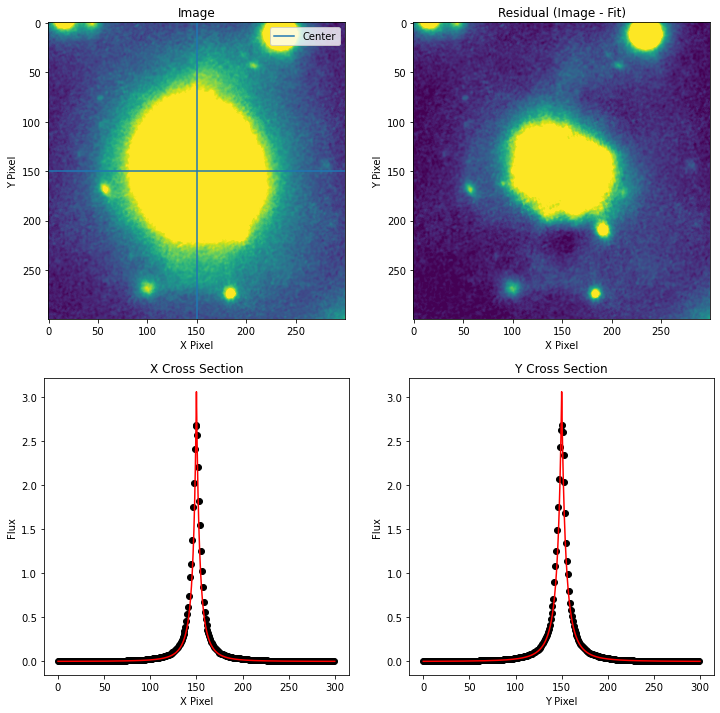

In [991]:
model.ellip = 0.2
plot_fit(target, model, vmin=0, vmax=mean_noise*40);

In [950]:
model.x_0

Parameter('x_0', value=50.0, fixed=True, bounds=(-50.0, 150.0))

('amplitude_0', 0.07073240339079723)
('x_0_0', 49.22246194020932)
('y_0_0', 50.93899614828019)
('gamma_0', 13.707857726833698)
('alpha_0', 902.8477376503392)
('ellip_0', 0.0)
('theta_0', 0.0)
('r_0', 28.373981273042773)
('amplitude_1', 0.0)
('r_eff_1', 20.763795796704255)
('n_1', 3.9880376572130625)
('x_0_1', 49.96440291988703)
('y_0_1', 50.00707582336899)
('ellip_1', 0.0)
('theta_1', 6.283185307179586)


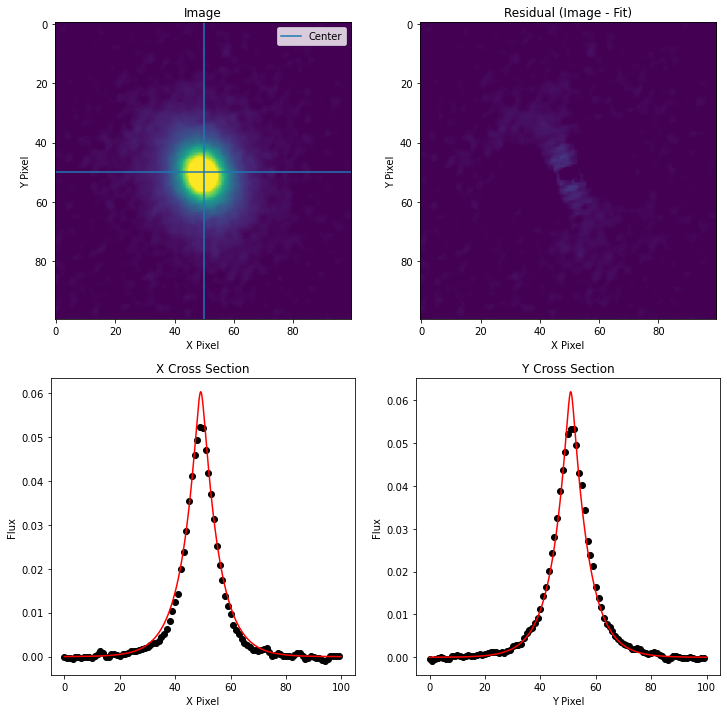

In [721]:
target = cutout(image, image.shape[0]//2, image.shape[0]//2, 100)
model = estimate_params2d(target, amp=target.max(), r_eff=20, n=3)

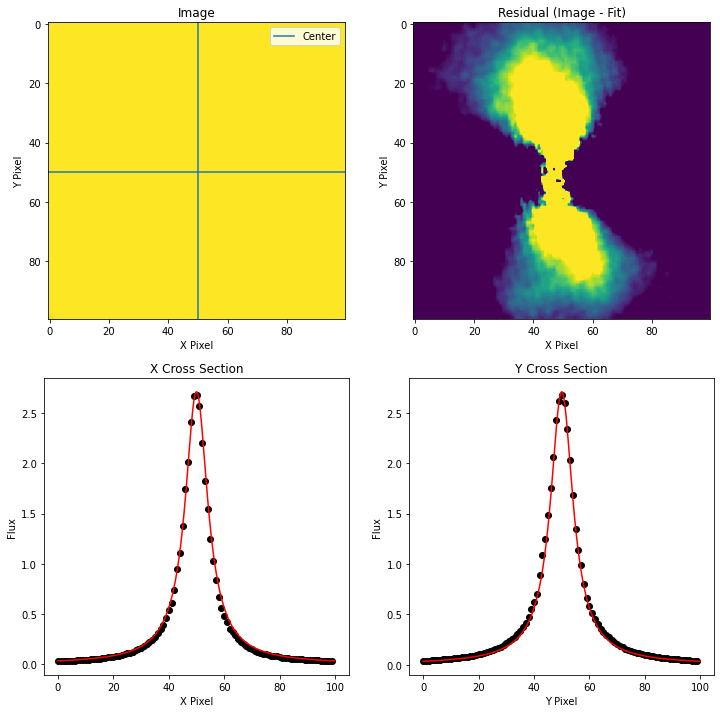

In [883]:
#model.ellip = 0.1
model.theta = 3*np.pi/4
plot_fit(target, model, vmin=0, vmax=mean_noise*40);

In [194]:

def plot_fit(image, model, vmin=None, vmax=None):
    if isinstance(model, models.Sersic2D):
        x_0, y_0 = model.x_0, model.y_0  # Center
    elif isinstance(model, models.Gaussian2D):
        x_0, y_0 = [i.value for i in [model.x_mean, model.y_mean]]
    else:
        x_0, y_0 = model.x_0, model.y_0  # Center
        
    if isinstance(x_0, Parameter):
        x_0, y_0 = [int(i.value) for i in [x_0, y_0]]

    fig = plt.figure(figsize=(12, 12))

    # Make x and y grid to plot to
    y_arange, x_arange = np.mgrid[:image.shape[0], :image.shape[1]]

    # Plot input image with FWHM and center
    # -------------------------------------
    ax0 = fig.add_subplot(221)

    ax0.imshow(image, vmin=vmin, vmax=vmax)
    ax0.axvline(x_0, label="Center")
    ax0.axhline(y_0)

    ax0.set_title("Image")
    ax0.set_xlabel("X Pixel")
    ax0.set_ylabel("Y Pixel")

    ax0.legend()

    # Plot residuals
    # ---------------

    residuals = image - model(x_arange, y_arange)
    residuals[np.where(residuals < 0)] = 0#np.nan
    ax1 = fig.add_subplot(222)
    ax1.imshow(residuals, vmin=vmin, vmax=vmax)

    ax1.set_title("Residual (Image - Fit)")
    ax1.set_xlabel("X Pixel")
    ax1.set_ylabel("Y Pixel")
    return 


    # Prepare fine grid
    # -----------------

    # We need a fine grid to fill in inter-pixel values
    # Oversample by a factor of 10

    y_arange_fine, x_arange_fine = np.mgrid[:image.shape[0] * 10, :image.shape[1] * 10] / 10

    fine_image = model(x_arange_fine, y_arange_fine)
    x_slice_fine = fine_image[fine_image.shape[0]//2, :]
    y_slice_fine = fine_image[:, fine_image.shape[1]//2]
    # Plot X fit
    # ----------

    ax2 = fig.add_subplot(223)

    ax2.plot(x_arange_fine[1, :], x_slice_fine, c='r')
    ax2.scatter(x_arange[1, :], image[int(np.round(y_0)), :], c='black')

    ax2.set_title("X Cross Section")
    ax2.set_xlabel("X Pixel")
    ax2.set_ylabel("Flux")

    # Plot Y fit
    # ----------

    ax3 = fig.add_subplot(224)

    ax3.plot(y_arange_fine[:, 1], y_slice_fine, c='r')
    ax3.scatter(y_arange[:, 1], image[:, int(np.round(x_0))], c='black')

    ax3.set_title("Y Cross Section")
    ax3.set_xlabel("Y Pixel")
    ax3.set_ylabel("Flux")

    return fig, [ax0, ax1, ax2, ax3]


('amplitude', 0.2918020057939014)
('r_eff', 16.37783913798291)
('n', 1.497301275307425)
('x_0', 100.0)
('y_0', 100.0)
('ellip', 0.0)
('theta', 6.283185307179586)


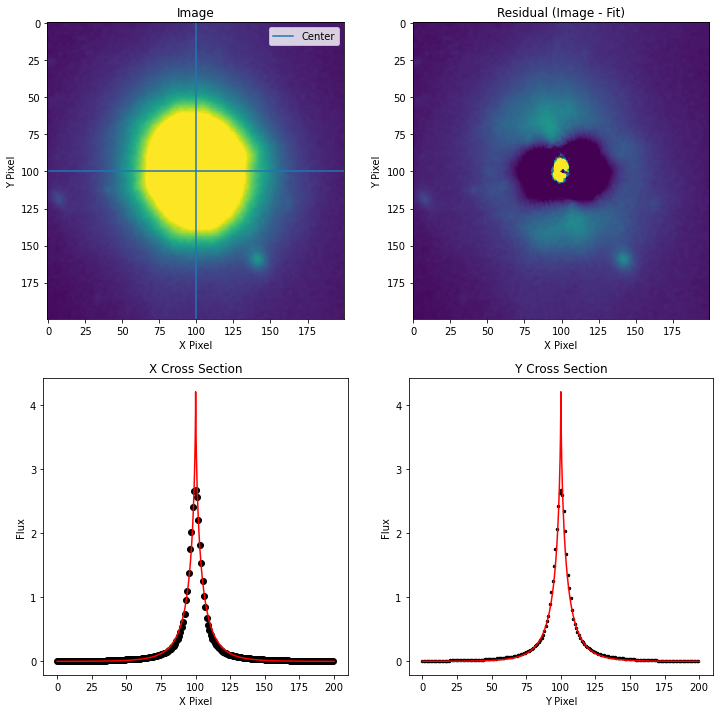

In [149]:
target = cutout(image, image.shape[0]//2, image.shape[0]//2, 200)
estimate_params2d(target, amp=target.max(), r_eff=20, n=3)

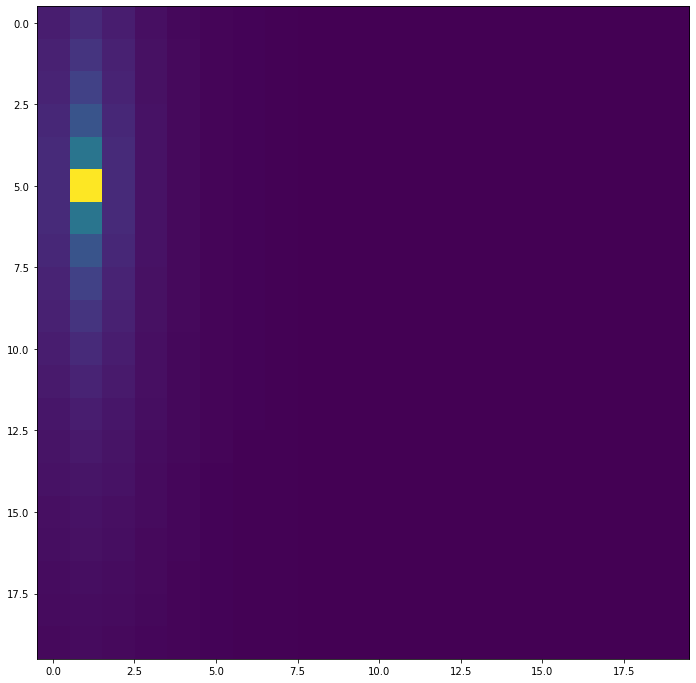

In [288]:
y_arange, x_arange = np.mgrid[:20, :20]
    
x = x_arange
y = y_arange


model = models.Sersic2D(
        amplitude=1,
        n=2,
        r_eff=30,
        ellip=0,
        theta=0,
        x_0 = 10,
        y_0 = 10,
    )


#kernel = AiryDisk2DKernel(8)
#kernel = Gaussian2DKernel(x_stddev=19, x_size=11, y_size=11)
#kernel.normalize()
image = model(x*10, y*2)
#image = convolve(image, kernel)
plt.imshow(image)

In [287]:
x*20

array([[  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
        260, 280, 300, 320, 340, 360, 380],
       [  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
        260, 280, 300, 320, 340, 360, 380],
       [  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
        260, 280, 300, 320, 340, 360, 380],
       [  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
        260, 280, 300, 320, 340, 360, 380],
       [  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
        260, 280, 300, 320, 340, 360, 380],
       [  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
        260, 280, 300, 320, 340, 360, 380],
       [  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
        260, 280, 300, 320, 340, 360, 380],
       [  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
        260, 280, 300, 320, 340, 360, 380],
       [  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 2

In [668]:
import numpy as np

def sersic(Ie, Re, R, m):
    bm = 2.0*m - 0.324
    return Ie * np.exp(-bm * ((R/Re)**(1.0/m) - 1.0))

def get_surface_brightness_profile(img):
    """
    img: a two dimensional array, dims (84,84)
    """
    pix = 0.06 # arcseconds/pixel
    n_bin = 100
    bins=100
    center_dist = np.sqrt((0.5*84)**2 + (0.5*84)**2)
    r_bin = .06 * center_dist * np.arange(bins) / float(bins)
    I_bin = np.zeros(n_bin, dtype=float)
    norm_bin = np.zeros(n_bin, dtype=float)
    
    for i in range(nx):
        for j in range(ny):
            ix = np.abs(0.5*nx - i) 
            iy = np.abs(0.5*ny - j)
            R  = np.sqrt(ix*ix + iy*iy) * pix        
            idx = bisect.bisect_left(r_bin,R)-1
            if((idx<n_bin-1) & (idx>0)):
                I_bin[idx] += img[i,j]
                norm_bin[idx] += 1.0
                
    ip = np.where(norm_bin>0)[0]
    I_bin[ip]/=norm_bin[ip]
    
    return (r_bin, I_bin)   


def sersic_optimize(x, m, y):
    """
    x: an indexed object with two items Ie=x[0], Re=[1]
    m: the m param for the sersic profile
    y: the measured surface brightness profile of the object
    """

    pix = .06  # arc/pixel
    bins = 100 # number of bins 
    center_dist = np.sqrt((0.5*84)**2 + (0.5*84)**2)
    r = .06 * center_dist * np.arange(bins) / float(bins)

    # get the sersic profile for Ie = x[0] and Re = x[1]
    s = sersic(x[0], x[1], r, m)

    # return the squared error
    return ((s[y>0]-y[y>0])**2).mean()

In [669]:
from scipy.optimize import fmin

img = image

# get the measured surface brightness profile
_, y = get_surface_brightness_profile(img)

# get the fit parameters
m = 1.0
init_Ie_Re = [1.0, 0.3]
opt_vals = fmin(sersic_optimize, init_Ie_Re, args(m, y))

# The returned values should be [0.01934633, 0.24175975]

NameError: name 'nx' is not defined